# **Challenge Valhalla**
**Rogelio Lizárraga Escobar A01742161**

## Importamos las librerías necesarias y hacemos nuestra conexión con Google Drive


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/Valhalla23.csv')


Mounted at /content/gdrive


## Guardamos los datos en un dataframe

In [2]:
df = pd.DataFrame(data)

## Definimos nuestro dataset y hacemos un split del 85% entre train y test

In [3]:
X = df[['Valks']].to_numpy()
y = df[['Celsius']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Regularización $L_1$, $L_2$ y ElasticNet

Se escoge el miodelo de regresión lineal para la resolución de este Challenge, pues explica la relación entre Valks y Celsius. Sin embargo, se le aplicó técnicas de regularización a esta regresión lineal por medio de:

* La regresión Lasso ($L_1$)

* La regresión Ridge ($L_2$)

* La regresión ElasticNet que fusiona la penalización de ambas regresiones


Con las funciones anteriores, se hará un GridSearch, donde se seleccionarán aquella regularización con el menor MSE, habiendo optimizado sus hiperparámetros ($\alpha$ para las tres regularizaciones y la proporción de las penalizaciones entre Lasso y Ridge $(L_{1_{Ratio}}$) para ElasticNet.

In [4]:
ridge = Ridge(max_iter = 10000)
lasso = Lasso(max_iter = 10000)
elastic_net = ElasticNet(max_iter = 10000)
hyper_grid_r = {'alpha': np.logspace(-50, 50, 50)}
hyper_grid_l = {'alpha': np.logspace(-50, 50, 50)}
hyper_grid_e_n = {'alpha': np.logspace(-50, 50, 50), 'l1_ratio': np.linspace(0, 1, 10)}


In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning) # Eliminamos los warnings de no convergencia
ridge_grid = GridSearchCV(ridge, hyper_grid_r, cv= 3, scoring='neg_mean_squared_error') # Seleccionamos como nuestra función costo -MSE, pues scikit maximiza scores.
ridge_grid.fit(X_train, y_train) # Entrenamos nuestro modelo
best_alpha_r = ridge_grid.best_params_['alpha'] #Guardamos el mejor alpha para ridge

# Hacemos lo mismo con Lasso y ElasticNet
lasso_grid = GridSearchCV(lasso, hyper_grid_l, cv= 3, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_alpha_l = lasso_grid.best_params_['alpha']

elastic_net_grid = GridSearchCV(elastic_net, hyper_grid_e_n, cv = 3, scoring='neg_mean_squared_error')
elastic_net_grid.fit(X_train, y_train)
best_alpha_elastic = elastic_net_grid.best_params_['alpha']
best_ratio_e_n = elastic_net_grid.best_params_['l1_ratio'] # Guardamos la mejor razón entre L1 y L2

In [6]:
# Entrenamos nuestros tres modelos con los hiperparámetros óptimos
star_ridge  = Ridge(alpha=best_alpha_r, max_iter = 10000)
star_ridge.fit(X_train, y_train)

star_lasso = Lasso(alpha=best_alpha_l, max_iter = 10000)
star_lasso.fit(X_train, y_train)

star_e_n = ElasticNet(alpha=best_alpha_elastic, l1_ratio=best_ratio_e_n, max_iter = 10000)
star_e_n.fit(X_train, y_train)


ElasticNet(alpha=10.481131341546917, l1_ratio=0.0, max_iter=10000)

Observamos que $\alpha^* = 10.4811$ y $L^*_{1_{Ratio}} = 0$, lo cual nos indica que la proporción entre $L_1$ y $L_2$ fue 0% contra 100%. Es decir, no se le aplicó regularización $L_1$.

In [7]:
# Hacemos nuestra predicciones para los tres modelos realizados
r_pred = star_ridge.predict(X_test)
l_pred = star_lasso.predict(X_test)
net_pred = star_e_n.predict(X_test)

In [8]:
# Encontramos los coeficientes de determinación de cada uno de los modelos, así como el MSE
ridge_r2 = round(r2_score(y_test, r_pred), 4)
lasso_r2 = round(r2_score(y_test, l_pred), 4)
net_r2 = round(r2_score(y_test, net_pred), 4)
print("---------------------------------------------------------")
print(f"Coeficiente de determinación de Ridge (R^2): {ridge_r2}")
print(f"Coeficiente de determinación de Lasso (R^2): {lasso_r2}")
print(f"Coeficiente de determinación de ElasticNet (R^2): {net_r2}")

ridge_mse = round(mean_squared_error(y_test, r_pred), 4)
lasso_mse = round(mean_squared_error(y_test, l_pred), 4)
net_mse =  round(mean_squared_error(y_test, net_pred), 4)
print("---------------------------------------------------------")
print(f"MSE Ridge: {ridge_mse}")
print(f"MSE Lasso: {lasso_mse}")
print(f"MSE ElasticNet: {net_mse}")


---------------------------------------------------------
Coeficiente de determinación de Ridge (R^2): 0.9967
Coeficiente de determinación de Lasso (R^2): 0.9968
Coeficiente de determinación de ElasticNet (R^2): 0.9967
---------------------------------------------------------
MSE Ridge: 3.0275
MSE Lasso: 2.9862
MSE ElasticNet: 3.0174


Observamos que $R_{lasso}^2 ≈ R_{ridge}^2 ≈ R_{Elastic_{Net}}^2 \approx 1$ y
también que $MSE_{lasso} ≈ MSE_{ridge} ≈ MSE_{Elastic_{Net}} $, siendo el mínimo el de Lasso = 2.99, lo cual es muy bueno, pues nos indica que el modelo se ajusta a los datos con casi un 100% y un error muy bajo. Es decir, el casi 100% de la variabilidad de la temperatura en Celsius puede ser explicada por la temperatura en "Valks".

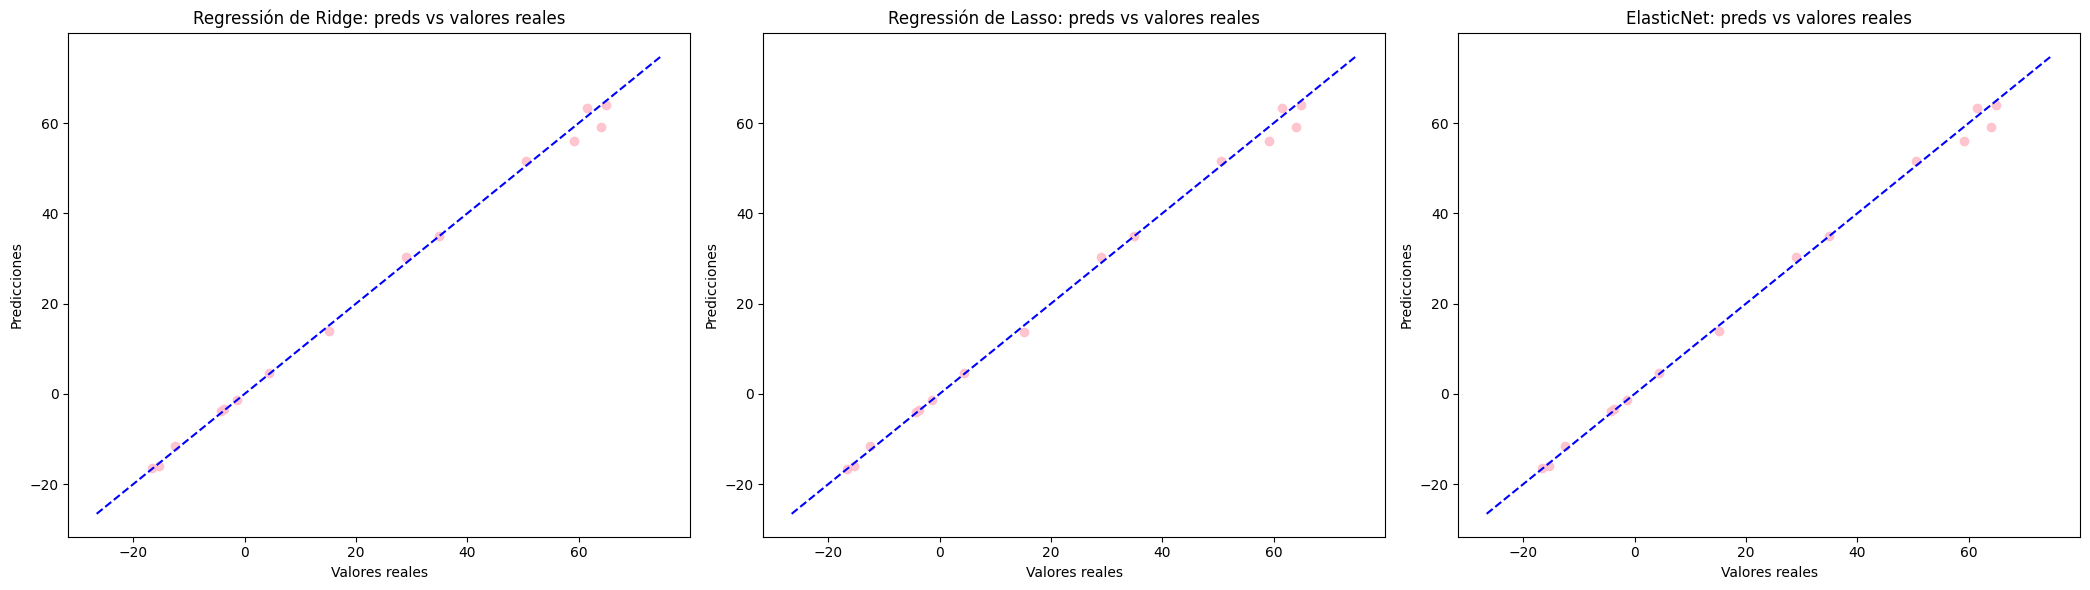

In [9]:
plt.figure(figsize=(21, 6))

# Graficamos las predicciones de Ridge contra los valores reales

plt.subplot(1, 3, 1)
plt.scatter(y_test, r_pred, alpha= 0.9, color = 'pink')
plt.plot([y_test.min()-10, y_test.max()+10], [y_test.min()-10, y_test.max()+10], 'b--')
plt.title('Regressión de Ridge: preds vs valores reales')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

# Graficamos las predicciones de Lasso contra los valores reales

plt.subplot(1, 3, 2)
plt.scatter(y_test, l_pred,  alpha= 0.9, color = 'pink')
plt.plot([y_test.min()-10, y_test.max()+10], [y_test.min()-10, y_test.max()+10], 'b--')
plt.title('Regressión de Lasso: preds vs valores reales')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

# Graficamos las predicciones de ElasticNet contra los valores reales

plt.subplot(1, 3, 3)
plt.scatter(y_test, net_pred,  alpha= 0.9, color = 'pink')
plt.plot([y_test.min()-10, y_test.max()+10], [y_test.min()-10, y_test.max()+10], 'b--')
plt.title('ElasticNet: preds vs valores reales')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()
